In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Input
from tensorflow.keras.optimizers import Adam, AdamW
tf.random.set_seed(2)

import pyhf

## Import the dataframe with the MC events

Background events have the label 0 and signal events have the label 1.

In [2]:
dataframe = pd.read_csv('dataframe.csv')

### Define train weights such that the sum of the weights for signal and background events is the same - the ratio of signal to background events is 1:1.

In [3]:
dataframe['train_weight'] = 1.
dataframe.loc[dataframe.query('label==1').index,'train_weight'] = (dataframe.loc[dataframe.query('label==1').index,'scaleweight']) / dataframe.loc[dataframe.query('label==1').index,'scaleweight'].sum()
dataframe.loc[dataframe.query('label==0').index,'train_weight'] = dataframe.loc[dataframe.query('label==0').index,'scaleweight'] / dataframe.loc[dataframe.query('label==0').index,'scaleweight'].sum()

sum_w_sig = dataframe.query('label==0')['train_weight'].sum()
sum_w_bkg = dataframe.query('label==1')['train_weight'].sum()
print(f'Sum of weights for training Signal {sum_w_sig:.3} and Background {sum_w_bkg:.3}')

Sum of weights for training Signal 1.0 and Background 1.0


In [4]:
train_features = ['etmiss', 'mtw', 'leadleptPt', 'leadleptEta',
       'leadleptE', 'leadleptPhi', 'Q_leadlep', 'leadleptID', 'n_TopLRjets',
       'leadTopLRjet_pt', 'leadTopLRjet_eta', 'leadTopLRjet_phi',
       'leadTopLRjet_m', 'leadTopLRjet_Tau32', 'n_jets', 'leadjet_pt',
       'leadjet_eta', 'n_bjets', 'leadbjet_pt', 'leadbjet_eta', 'ttbarMLR']

weights = ["scaleweight", "train_weight", "label"]

### Define the train, validation and test datasets.

In [5]:
x_train, x_val, y_train, y_val, w_train_full, w_val_full = train_test_split(dataframe[train_features].values, dataframe['label'].values, dataframe[weights].values, train_size = 1/3, random_state = 9)
x_val, x_test, y_val, y_test, w_val_full, w_test_full = train_test_split(x_val, y_val, w_val_full, test_size=1/2, random_state = 9)


scaler1 = StandardScaler()
scaler1.fit(x_train)

x_train_1 = scaler1.transform(x_train)
y_train_1 = y_train
x_val_1 = scaler1.transform(x_val)
y_val_1 = y_val
x_test_1 = scaler1.transform(x_test)
y_test_1 = y_test

scaler2 = StandardScaler()
scaler2.fit(x_test)

x_train_2 = scaler2.transform(x_test)
y_train_2 = y_test
x_val_2 = scaler2.transform(x_train)
y_val_2 = y_train
x_test_2 = scaler2.transform(x_val)
y_test_2 = y_val

scaler3 = StandardScaler()
scaler3.fit(x_val)

x_train_3 = scaler3.transform(x_val)
y_train_3 = y_val
x_val_3 = scaler3.transform(x_test)
y_val_3 = y_test
x_test_3 = scaler3.transform(x_train)
y_test_3 = y_train


In [6]:
def weight_separation(w):
    scaleweights = w[:, 0]
    train = w[:, 1]
    label = w[:, 2]
    return scaleweights, train, label

w_train_scale, w_train, label_train = weight_separation(w_train_full)
w_val_scale, w_val, label_val = weight_separation(w_val_full)
w_test_scale, w_test, label_test = weight_separation(w_test_full)

# Neural Network

We define 3 models with the same architecture and hyperparameters. 
Model 1:
- Training set: x_train, y_train
- Validation set: x_val, y_val
- Test set: x_test, y_test

Model 2:
- Training set: x_test, y_test
- Validation set: x_train, y_train
- Test set: x_val, y_val

Model 3:
- Training set: x_val, y_val
- Validation set: x_test, y_test
- Test set: x_train, y_train

Finally to compare the models we calculate the ROC AUC score for each model on the test set.
Later we use the predicted values of the test set used in each model to calculate the upper limits for the mu.

### MODEL 1
- Training set: x_train, y_train
- Validation set: x_val, y_val
- Test set: x_test, y_test

In [7]:
model1 = Sequential([Input(shape=(x_train.shape[1],))])

# Input and Hidden layers
model1.add(Dense(75, activation='softsign'))
model1.add(Dropout(0.1))
model1.add(Dense(125, activation='softsign'))
model1.add(Dense(125, activation='relu'))
model1.add(Dense(75, activation='relu'))

# Output layer
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-1), weighted_metrics=['accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 75)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 125)            │         9,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         9,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,426 (142.29 KB)

 Trainable params: 36,426 (142.29 KB)

 Non-trainable params: 0 (0.00 B)

### MODEL 2:
- Training set: x_test, y_test
- Validation set: x_train, y_train
- Test set: x_val, y_val

In [8]:
model2 = Sequential([Input(shape=(x_train.shape[1],))])

# Input and Hidden layers
model2.add(Dense(75, activation='softsign'))
model2.add(Dropout(0.1))
model2.add(Dense(125, activation='softsign'))
model2.add(Dense(125, activation='relu'))
model2.add(Dense(75, activation='relu'))

# Output layer
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-1), weighted_metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 75)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 125)            │         9,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 75)             │         9,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,426 (142.29 KB)

 Trainable params: 36,426 (142.29 KB)

 Non-trainable params: 0 (0.00 B)

### Model 3:
- Training set: x_val, y_val
- Validation set: x_test, y_test
- Test set: x_train, y_train

In [9]:
model3 = Sequential([Input(shape=(x_train.shape[1],))])

# Input and Hidden layers
model3.add(Dense(75, activation='softsign'))
model3.add(Dropout(0.1))
model3.add(Dense(125, activation='softsign'))
model3.add(Dense(125, activation='relu'))
model3.add(Dense(75, activation='relu'))

# Output layer
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-1), weighted_metrics=['accuracy'])
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 75)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 125)            │         9,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 75)             │         9,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,426 (142.29 KB)

 Trainable params: 36,426 (142.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history1 = model1.fit(x_train_1, y_train_1, sample_weight=w_train, validation_data=(x_val_1, y_val_1, w_val), epochs=100, batch_size=1024, callbacks=[EarlyStopping(patience=2)], verbose=0)
history2 = model2.fit(x_train_2, y_train_2, sample_weight=w_test, validation_data=(x_val_2, y_val_2, w_train), epochs=100, batch_size=1024, callbacks=[EarlyStopping(patience=2)], verbose=0)
history3 = model3.fit(x_train_3, y_train_3, sample_weight=w_val, validation_data=(x_val_3, y_val_3, w_test), epochs=100, batch_size=1024, callbacks=[EarlyStopping(patience=2)], verbose=0)

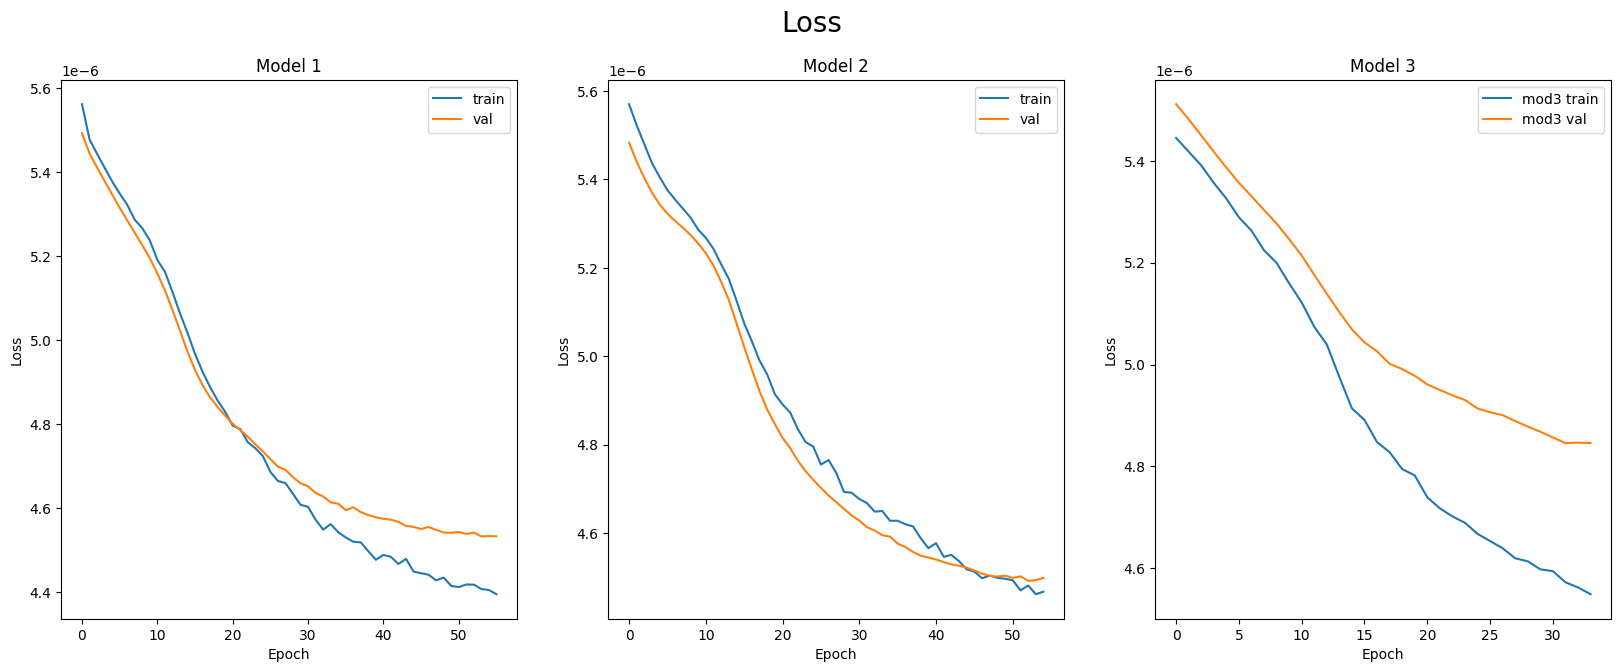

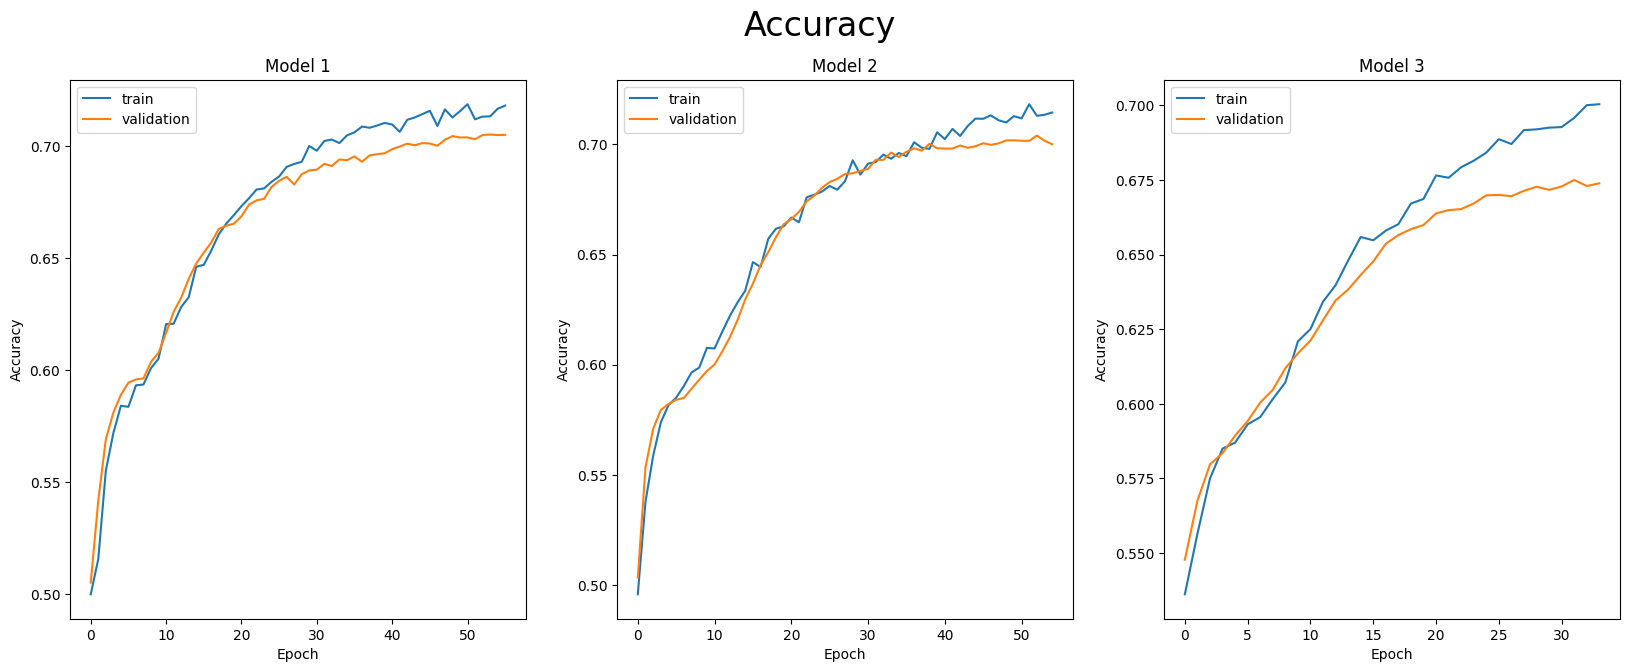

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(history1.history['loss'], label='train')
ax[0].plot(history1.history['val_loss'], label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title("Model 1")
ax[0].legend()
ax[1].plot(history2.history['loss'], label='train')
ax[1].plot(history2.history['val_loss'], label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title("Model 2")
ax[1].legend()
ax[2].plot(history3.history['loss'], label='mod3 train')
ax[2].plot(history3.history['val_loss'], label='mod3 val')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title("Model 3")
ax[2].legend()

fig.suptitle('Loss', fontsize=20)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].plot(history1.history['accuracy'], label='train')
ax[0].plot(history1.history['val_accuracy'], label='validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title("Model 1")
ax[0].legend()
ax[1].plot(history2.history['accuracy'], label='train')
ax[1].plot(history2.history['val_accuracy'], label='validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title("Model 2")
ax[1].legend()
ax[2].plot(history3.history['accuracy'], label='train')
ax[2].plot(history3.history['val_accuracy'], label='validation')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title("Model 3")
ax[2].legend()

fig.suptitle('Accuracy', fontsize=24)
plt.show()

In [12]:
y_test_pred_1 = model1.predict(x_test_1)
y_test_pred_2 = model2.predict(x_test_2)
y_test_pred_3 = model3.predict(x_test_3)

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1s 216us/step
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 1s 214us/step


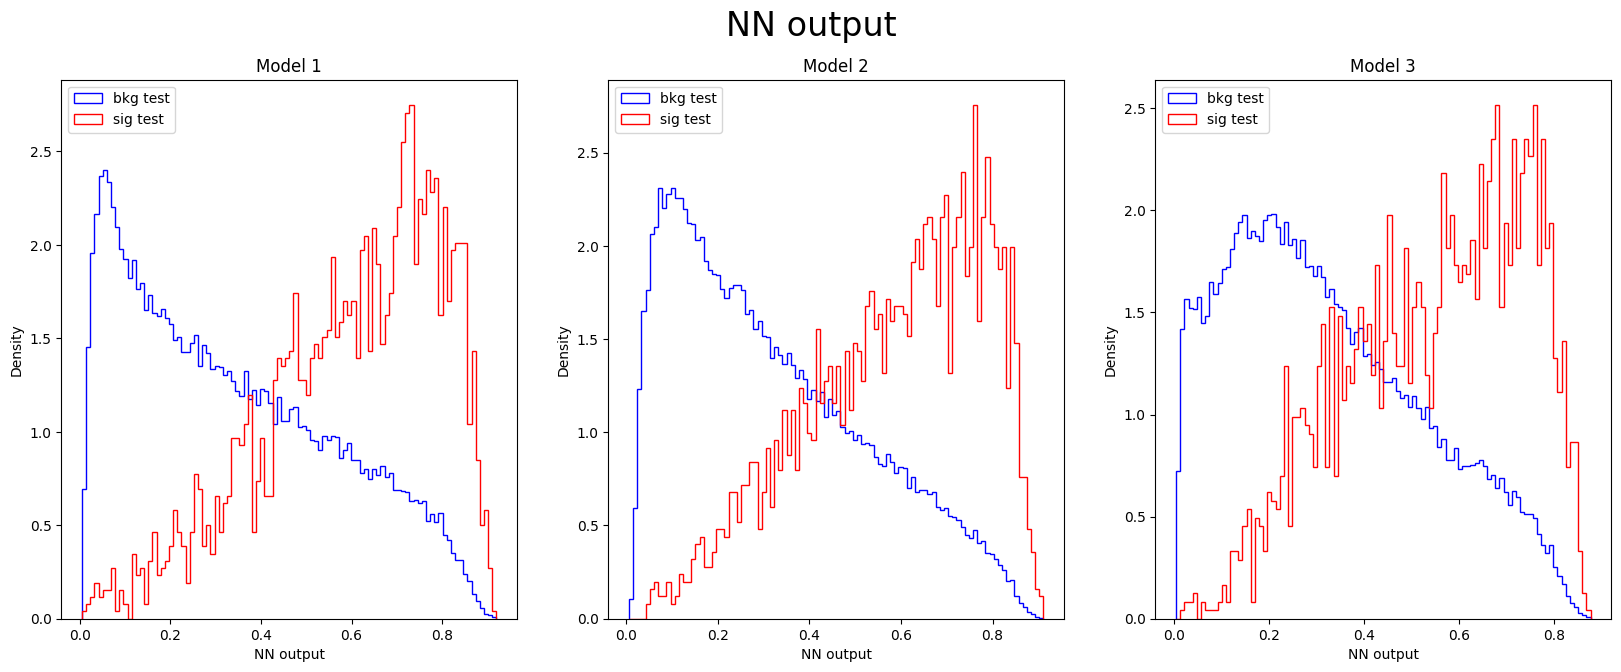

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
bin = ax[0].hist(y_test_pred_1[y_test_1==0], bins=100, density=True, histtype='step', color='blue', label='bkg test')
ax[0].hist(y_test_pred_1[y_test_1==1], bins=bin[1], density=True, histtype='step', color='red', label='sig test')
ax[0].set_title('Model 1')
ax[0].set_xlabel('NN output')
ax[0].set_ylabel('Density')
ax[0].legend()
bin = ax[1].hist(y_test_pred_2[y_test_2==0], bins=100, density=True, histtype='step', color='blue', label='bkg test')
ax[1].hist(y_test_pred_2[y_test_2==1], bins=bin[1], density=True, histtype='step', color='red', label='sig test')
ax[1].set_title('Model 2')
ax[1].set_xlabel('NN output')
ax[1].set_ylabel('Density')
ax[1].legend()
bin = ax[2].hist(y_test_pred_3[y_test_3==0], bins=100, density=True, histtype='step', color='blue', label='bkg test')
ax[2].hist(y_test_pred_3[y_test_3==1], bins=bin[1], density=True, histtype='step', color='red', label='sig test')
ax[2].set_title('Model 3')
ax[2].set_xlabel('NN output')
ax[2].set_ylabel('Density')
ax[2].legend()

fig.suptitle('NN output', fontsize=24)
plt.show()

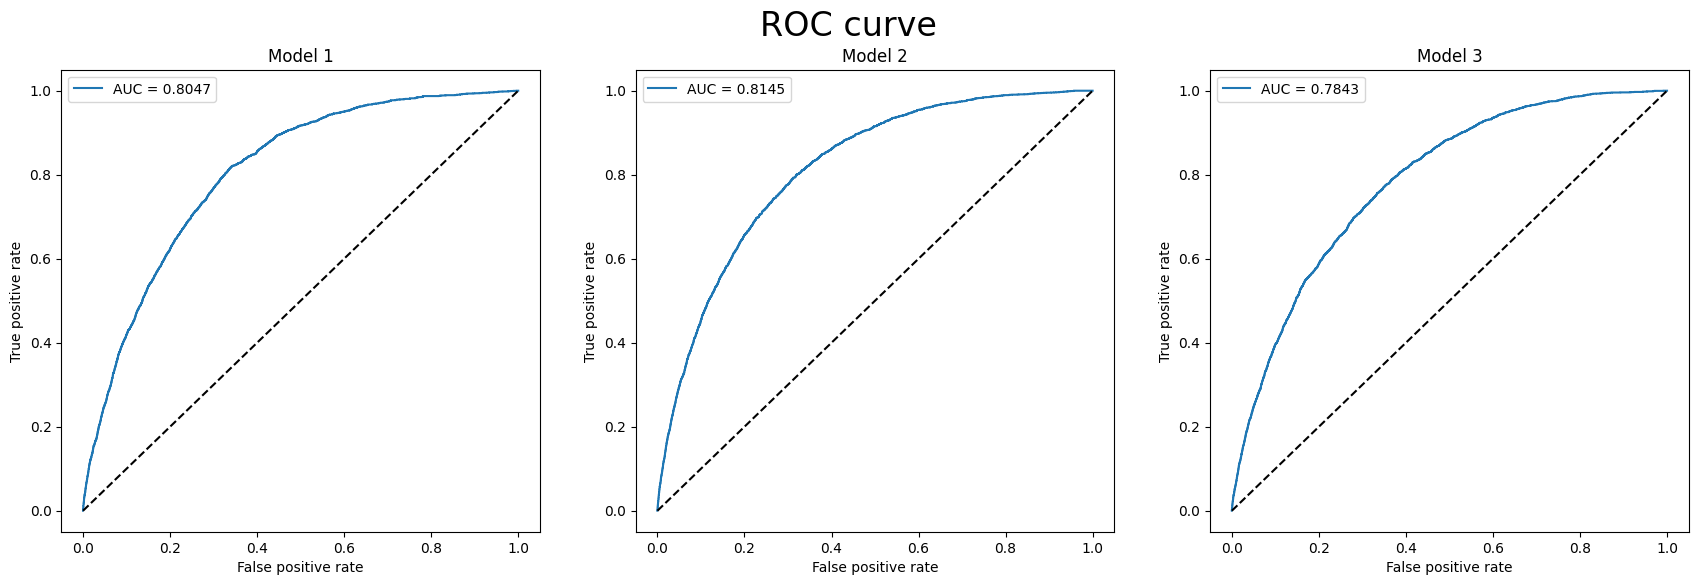

In [14]:
# ROC curve
fpr1, tpr1, thresholds1 = roc_curve(y_test_1, y_test_pred_1)
fpr2, tpr2, thresholds2 = roc_curve(y_test_2, y_test_pred_2)
fpr3, tpr3, thresholds3 = roc_curve(y_test_3, y_test_pred_3)

auc1 = roc_auc_score(y_test, y_test_pred_1)
auc2 = roc_auc_score(y_val, y_test_pred_2)
auc3 = roc_auc_score(y_train, y_test_pred_3)

fig, ax = plt.subplots(1, 3, figsize=(21, 6))
ax[0].plot(fpr1, tpr1, label=f'AUC = {auc1:.4f}')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='black')
ax[0].set_title('Model 1')
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].legend()
ax[1].plot(fpr2, tpr2, label=f'AUC = {auc2:.4f}')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='black')
ax[1].set_title('Model 2')
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].legend()
ax[2].plot(fpr3, tpr3, label=f'AUC = {auc3:.4f}')
ax[2].plot([0, 1], [0, 1], linestyle='--', color='black')
ax[2].set_title('Model 3')
ax[2].set_xlabel('False positive rate')
ax[2].set_ylabel('True positive rate')
ax[2].legend()

fig.suptitle('ROC curve', fontsize=24)
plt.show()

In [15]:
# join the y predictions and scaleweights into a dataframe with two columns
def join_y_w(y1, w1, label1, y2, w2, label2, y3, w3, label3):
    df1 = pd.DataFrame({'y_pred': y1, 'scaleweights': w1, 'label': label1})
    df2 = pd.DataFrame({'y_pred': y2, 'scaleweights': w2, 'label': label2})
    df3 = pd.DataFrame({'y_pred': y3, 'scaleweights': w3, 'label': label3})
    df = pd.concat([df1, df2, df3])
    return df

df_test = join_y_w(y_test_pred_1[:, 0], w_test_scale, label_test,
                   y_test_pred_2[:, 0], w_val_scale, label_val,
                   y_test_pred_3[:, 0], w_train_scale, label_train)
df_test

,y_pred,scaleweights,label
0,0.216306,0.098242,0.0
1,0.628040,0.074445,1.0
2,0.362728,0.003316,0.0
3,0.105896,0.003412,0.0
4,0.209007,0.103947,0.0
...,...,...,...
84027,0.312556,0.095500,0.0
84028,0.443552,0.030424,0.0
84029,0.306786,0.032826,0.0
84030,0.328994,0.116259,0.0


In [16]:
data = pd.read_csv('Output_ZPrimeBoostedAnalysis/data.csv', delimiter= " ")
data

,etmiss,mtw,leadleptPt,leadleptEta,leadleptE,leadleptPhi,Q_leadlep,leadleptID,n_TopLRjets,leadTopLRjet_pt,...,n_bjets,leadbjet_pt,leadbjet_eta,ttbarMLR,largeRjet_pt_total,largeRjet_eta_total,largeRjet_phi_total,largeRjet_m_total,largeRjet_tau32_total,weight
0,140.8590,112.6010,173.3020,-0.719597,220.1410,-0.629445,1,11,1,303.808,...,2,74.2067,1.155760,0.000,303.808,0.716499,2.340630,105.440,0.701667,1
1,101.1240,12.9607,84.2450,0.521832,95.9780,1.694020,1,13,1,319.519,...,1,229.1180,-0.005455,0.000,319.519,-0.207688,-1.050650,124.417,0.658574,1
2,93.8502,145.9590,69.5917,-0.571767,81.2804,2.401100,1,11,1,379.502,...,1,354.8290,0.387903,0.000,379.502,0.429905,-0.032258,101.729,0.705147,1
3,79.1584,78.5076,39.4455,0.320825,41.4930,1.189650,-1,11,1,364.358,...,2,111.3740,-1.131620,0.000,673.232,-0.882717,2.047210,211.584,1.222030,1
4,49.9677,119.0770,78.1793,-1.261530,149.0890,-0.060379,1,11,1,381.640,...,4,327.3410,-0.637407,836.840,749.172,-1.939400,-0.584009,245.185,1.182330,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13983,51.2650,36.3069,32.4356,-1.826030,103.3120,2.875370,1,11,1,313.153,...,1,63.3124,-2.219060,0.000,313.153,-1.469270,-0.309966,149.170,0.428863,1
13984,177.2230,98.1917,226.8500,0.625051,272.6260,2.951550,-1,13,1,403.237,...,1,79.7143,0.725713,858.712,403.237,-0.551284,-0.521822,163.453,0.696539,1
13985,379.7260,76.7778,38.0448,0.559037,44.1463,-2.853520,1,13,1,618.111,...,2,120.5620,2.143520,0.000,883.045,1.610580,-3.028970,283.641,1.011700,1
13986,76.5990,32.0798,68.3700,-0.439462,75.0790,-0.758893,1,11,1,336.483,...,1,173.8460,1.078890,0.000,336.483,1.348570,1.986230,103.251,0.382302,1


In [17]:
x_data = scaler1.transform(data[train_features].values)
w_data = data["weight"].values

In [18]:
y_data_pred = model1.predict(x_data)

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


In [19]:
def join_y_w(y, w):
    df = pd.DataFrame({'y_pred': y, 'scaleweights': w})
    return df
df_data = join_y_w(y_data_pred[:, 0], w_data[:])

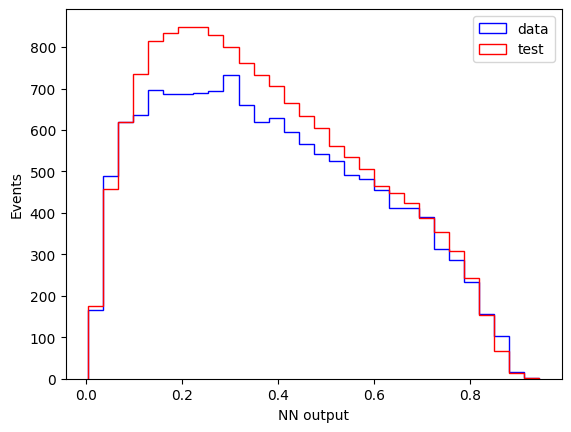

In [20]:
bins = plt.hist(df_data['y_pred'], bins=30, histtype='step', color='blue', label='data', weights=df_data['scaleweights'])
plt.hist(df_test['y_pred'], bins=bins[1], histtype='step', color='red', label='test', weights=df_test['scaleweights'])
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()

In [21]:
N, bins = np.histogram(df_data['y_pred'], bins=50, weights=df_data['scaleweights'])

B = np.histogram(df_test['y_pred'][df_test["label"]==0], bins=bins, weights=df_test['scaleweights'][df_test["label"]==0])[0]
S = np.histogram(df_test['y_pred'][df_test["label"]==1], bins=bins, weights=df_test['scaleweights'][df_test["label"]==1])[0]


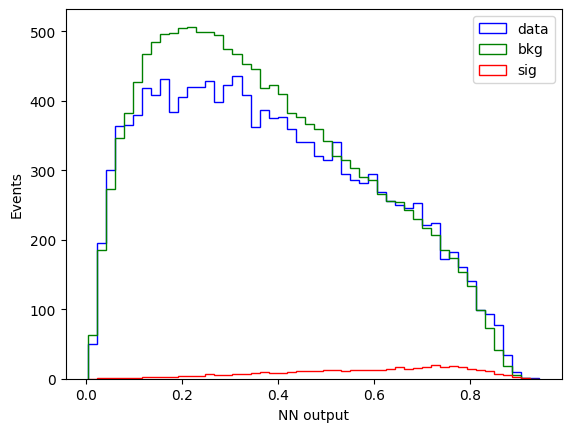

In [22]:
# Plot N, S, B
plt.hist(bins[:-1], bins, weights=N, histtype='step', color='blue', label='data')
plt.hist(bins[:-1], bins, weights=B, histtype='step', color='green', label='bkg')
plt.hist(bins[:-1], bins, weights=S, histtype='step', color='red', label='sig')
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()
plt.show()

In [23]:
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': S.tolist(),
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg1','data': B.tolist(),
               'modifiers': []},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": N.tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": "mu", "parameters": []}}],
              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

data = N.tolist() + model.config.auxdata

test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.01, 5, 500)
obs_limit, exp_limits = pyhf.infer.intervals.upper_limits.upper_limit(data, model, poi_values, level=0.05)
print(f"\nObserved μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")

/Users/joaobiu/miniconda3/envs/root-env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: inf
       x: [ 1.000e+00]
     nit: 1
     jac: [       nan]
    nfev: 2
    njev: 1
Traceback (most recent call last):
  File "/Users/joaobiu/miniconda3/envs/root-env/lib/python3.11/site-packages/pyhf/optimize/mixins.py", line 63, in _internal_minimize
    assert result.success
           ^^^^^^^^^^^^^^
AssertionError


## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 50}
   samples: ['bkg1', 'signal']
 modifiers: [('mu', 'normfactor')]
parameters: ['mu']
par. order: ['mu']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]


FailedMinimization: Inequality constraints incompatible